In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
doc = nlp(u'A man and a boy are playing computer and sitting on the ground in the wild. A woman is waving under the tree. A girl is sitting on the chair. A man is lying on the sofa playing games. There are some trees and plants and flowers in the park. An alien is lying crying.')
# parse(doc)
# 'he is '
# 'mike is'
for token in doc:
    print("{2}({3}-{6}, {0}:{1}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))

det(man-2, A:DT-1)
nsubj(playing-7, man:NN-2)
cc(man-2, and:CC-3)
det(boy-5, a:DT-4)
conj(man-2, boy:NN-5)
aux(playing-7, are:VBP-6)
ROOT(playing-7, playing:VBG-7)
dobj(playing-7, computer:NN-8)
cc(playing-7, and:CC-9)
conj(playing-7, sitting:VBG-10)
prep(sitting-10, on:IN-11)
det(ground-13, the:DT-12)
pobj(on-11, ground:NN-13)
prep(sitting-10, in:IN-14)
det(wild-16, the:DT-15)
pobj(in-14, wild:NN-16)
punct(playing-7, .:.-17)
det(woman-19, A:DT-18)
nsubj(waving-21, woman:NN-19)
aux(waving-21, is:VBZ-20)
ROOT(waving-21, waving:VBG-21)
prep(waving-21, under:IN-22)
det(tree-24, the:DT-23)
pobj(under-22, tree:NN-24)
punct(waving-21, .:.-25)
det(girl-27, A:DT-26)
nsubj(sitting-29, girl:NN-27)
aux(sitting-29, is:VBZ-28)
ROOT(sitting-29, sitting:VBG-29)
prep(sitting-29, on:IN-30)
det(chair-32, the:DT-31)
pobj(on-30, chair:NN-32)
punct(sitting-29, .:.-33)
det(man-35, A:DT-34)
nsubj(lying-37, man:NN-35)
aux(lying-37, is:VBZ-36)
ROOT(lying-37, lying:VBG-37)
prep(lying-37, on:IN-38)
det(games-42,

In [5]:
# from rules.labels import subjects
from tools.knowledge import LayerBase, TextBase
layerbase = LayerBase()
# prs_subjects = set([subj for subj in layerbase.entities_['subj'] if subj in subjects['character']])
# prs_subjects

In [7]:
# similairties between subjects: the largest common subset
#     E.g. 1. text: man man and base: man woman
#              man - man: 1 + man - woman: 0.5
#          2. TEXT: man man and BASE: man
#              man - man: 1
#              so choose man and woman


In [166]:
# from rules.labels import subjects
from collections import defaultdict
from tools.common import ddict2dict
from tools.instance import Node
from query_relatedness import query_simi

# class Ground:
#     def __init__(self):
#         self.layerbase = LayerBase()
#         self.prs_subjects = set([subj for subj in layerbase.entities_['subj'] if subj in subjects['character']])
#         # self.srd_subjects = 

def incre_name(s, dic):
    count = 0
    for k in dic:
        # remove any tail digits
        sub = re.sub(r'(?<=\w)\d+$','', k)
        if re.match(r'%s\d*' % sub, s):
            # print(count, r'%s\d*' % sub, s)
            count += 1
    if count > 0:
        return '%s%i' % (s, count)
    return s

def get_tokens(doc):
    return [t for t in doc if not t.is_stop and not t.is_punct]

def get_simi_keyword(token, keywords, thresh=0.5):
    
    tups = [(k, query_simi(token.lemma_, k.t)) for k in keywords]
    simi_key, simi_ = sorted(tups, key=lambda x: (x[1], x[0].count))[-1]
    if simi_ >= thresh:
        return simi_key, simi_
#     return None
#     for keyword in keywords:
#         if  > thresh:
#             return keyword
    return None

class MappedToken:
    def __init__(self, token, keyword):
        if token:
            assert(isinstance(token, spacy.tokens.token.Token))
        assert(isinstance(keyword, Node))
        self.token = token
        self.keyword = keyword
        
        self.tup = (self.token, self.keyword)
        
    def __repr__(self):
        if self.token is None:
            return '->%s' % (self.keyword.t)
        return '%s->%s' % (self.token.lemma_, self.keyword.t)
    
    def __eq__(self, other):
        return self.tup == other.tup
    
    def __hash__(self):
        return hash(self.tup)
    
def ground_subj(tokens_, nested_):
    
    ## query the base to identify a subject
    tokens_copy = tokens_.copy()
    subjs = [subj for subj in layerbase.collocations_]
    for token in tokens_copy:
        if token.pos_ == 'NOUN':
            tup = get_simi_keyword(token, subjs, thresh=0.5)
            if tup:
                subj_, _ = tup
                tokens_.remove(token)
                nested_[MappedToken(token, subj_)] = defaultdict(set)
#         for type_ in subjects:
#             if token.lemma_ in subjects[type_]:
#                 tokens_.remove(token)
#                 nested_[token] = defaultdict(set)
#                 if token.lemma_ not in nested_:
#                     map_dict[token] = token.lemma_
#                     nested_[token.lemma_] = defaultdict(set)
#                 else:
#                     lemma_i = incre_name(token.lemma_, nested_)
#                     map_dict[token] = lemma_i
#                     nested_[lemma_i] = defaultdict(set)

def bind_keyword(token, subj, act=None, thresh=0.3):
    # bind keyword
    if act is None:
        # used to bind actions
        # keywords = [k for k in layerbase.collocations_[subj]]
        keywords = [k for k in layerbase.entities_['act']]
        attr = 'act'
    else:
        # used to bind objects
        # maybe, search all objects regardless of subj and act
#         if act == Node('', attr='act'):
#             # unbound action, retrieve objects under all actions under this subject
#             keywords = [k for a in layerbase.collocations_[subj] for k in layerbase.collocations_[subj][a]]
#         else:
#             # bound action, retrieve objects under this subject and this actions
#             keywords = [k for k in layerbase.collocations_[subj][act]]
        keywords = [k for k in layerbase.entities_['obj']]
        attr = 'obj'
        
    tup = get_simi_keyword(token, keywords, thresh=thresh)
    if tup:
        k_, _ = tup
    else:
        k_ = Node('', attr=attr)
    return MappedToken(token, k_)

def find_most_simi_subj(subjs, token, dest='obj'):
    assert(isinstance(token, spacy.tokens.token.Token))
    assert(all([isinstance(subj, Node) for subj in subjs]))
    # assert(all([s.t in subjects['surrounding'] for s in subjs]))
    # search all subjects, not just surrounding subjects. E.g. Alien have robot
    if dest == 'obj':
        assert(all([Node('have', attr='act') in layerbase.collocations_[s] for s in subjs]))
    elif dest == 'act':
        pass
    else:
        raise KeyError
        
    most_simi_ = []
    for subj in subjs:
        if dest == 'obj':
            tup = get_simi_keyword(token,
                                   layerbase.collocations_[subj][Node('have', attr='act')],
                                   thresh=0.2)
        elif dest == 'act' :
            if not layerbase.collocations_[subj]: continue
            tup = get_simi_keyword(token, layerbase.collocations_[subj], thresh=0.2)
        else:
            raise KeyError
        if tup:
            most_simi_.append((subj,) + tup)
            
    if most_simi_:
        print(most_simi_)
        if dest == 'obj':
            sort_f = lambda x: (x[-1], get_element_from_set(layerbase.collocations_[x[0]][Node('have', attr='act')], x[1]).count)
        elif dest == 'act':
            sort_f = lambda x: (x[-1], get_element_from_set(layerbase.collocations_[x[0]], x[1]).count)
        else:
            raise KeyError
        return sorted(most_simi_, key=sort_f)[-1]
    return None

def ground_act(tokens_, nested_):
    
    ## ---- syntactical parency
    tokens_copy = tokens_.copy()
    for token in tokens_copy:
        for key in nested_:
            if token == key.token.head:
                assert(key.token.dep_ == 'nsubj'), key.token.dep_
                tokens_.remove(token)
                
                # bind keyword
#                 acts = [a for a in layerbase.collocations_[key.keyword]]
#                 tup = get_simi_keyword(token, acts, thresh=0.3)
#                 if tup:
#                     act_, _ = tup
#                 else:
#                     act_ = Node('', attr='act')
                # print(token, key.keyword)
                nested_[key][bind_keyword(token, key.keyword)] = set()
    
    ## ---- conjuncted verbs
    tokens_copy = tokens_.copy()
    # cannot pickle a spacy.token
    ## nested_copy = deepcopy(nested_)
    # cannnot modify a dict during iteration, thus save keys
    saved_tups = []
    for token in tokens_copy:
        for subj in nested_:
            for act in nested_[subj]:
                if token.head == act.token and token.pos_ == 'VERB':
                    assert(token.dep_ in ['conj', 'xcomp', 'advcl']), token.dep_
                    tokens_.remove(token)
                    saved_tups.append((subj, token))
    for subj, token in saved_tups:   
        nested_[subj][bind_keyword(token, subj.keyword)] = set()
    
    ## ---- other verbs
    ### if the verb has the common root with any of the subjects, bind it. This cause confusion when a sentence contains two or more subjects
    tokens_copy = tokens_.copy()
    saved_tups = []
    for token in tokens_copy:
        if token.pos_ == 'VERB':
            for subj in nested_:
                if token.sent.root == subj.sent.root:
                    tokens_.remove(token)
                    saved_tups.append(subj, token)
    for subj, token in saved_tups:
        nested_[subj][bind_keyword(token, subj.keyword)] = set() 
        
    ### finally if still some verbs left, use knowledge base
    ## subject-object collocation knowledge ground, subjects in the layerbase
    tokens_copy = tokens_.copy()
    saved_tups = []
    subjs = [subj for subj in layerbase.collocations_]
    for token in tokens_copy:
        if token.pos_ == 'VERB':
            tup = find_most_simi_subj(subjs, token, dest='act')
            if tup:
                subj_, act_, s_ = tup
                tokens_.remove(token)
                saved_tups.append((subj_, act_, token))
    for subj, act, token in saved_tups:
        nested_[MappedToken(None, subj)][MappedToken(token, act)] = set()
    
# static var stuff
# related dict needs to transformed to dict
# def query_related(t, k):
#     import dill
#     with open('relateDict.pkl', 'rb') as f:
#         relateDict = dill.load(f) 
#     if k in relateDict and t in relateDict[k]:
#         return relateDict[k][t]
    
#     import requests
#     return requests.get('http://api.conceptnet.io/relatedness?node1=/c/en/%s&node2=/c/en/%s' % (k, t)).json()['value']

def get_element_from_set(set_, e_):
    for e in set_:
        if e == e_:
            return e


        
def ground_obj(tokens_, nested_):
    
    ## syntactically ground
    ### E.g. man plays computer: computer -> play -> man
    tokens_copy = tokens_.copy()
    saved_tups = []
    for token in tokens_copy:
        for subj in nested_:
            for act in nested_[subj]:
                if token.head == act.token and token.pos_ == 'NOUN':
                    if token.dep_ in ['dobj']:
                        # unbound subjects are neglected, such as "couple"
                        tokens_.remove(token)
                        saved_tups.append((subj, act, token))
    for subj, act, token in saved_tups:
        # nested_[subj][act].add(token)
        nested_[subj][act].add(bind_keyword(token, subj.keyword, act=act.keyword))
        
    # ground to current surrounding subjects based on knowledge
    ## subject-object collocation knowledge ground, current subjects only
    ### surrounding only. because obj in character must be syntactically grounded
    ### not necessarily, obj can be knowledgely grounded to characters if th action is have. E.g. Alien have robot
    
    ## srd_subjects = [(subj.keyword, subj) for subj in nested_ if subj.keyword.t in subjects['surrounding']]
    srd_subjects = [(subj.keyword, subj) for subj in nested_ if Node('have', attr='act') in layerbase.collocations_[subj.keyword]]
    ## if no surrounding subjects are captured now, skip this step
    if srd_subjects:
        subjs, mapped = zip(*srd_subjects)
        tokens_copy = tokens_.copy()
        saved_tups = []

        for token in tokens_copy:
            tup = find_most_simi_subj(subjs, token)
            if tup:
                subj_, obj_, s_ = tup
                # print(token, obj_, s_, subj_)
                tokens_.remove(token)
                ## use original text in the description as key
                ## or use grounding keyword as key
                # saved_tups.append((subj, token))
                saved_tups.append((mapped[subjs.index(subj_)], obj_, token))
        for subj, obj, token in saved_tups:
            if MappedToken(None, Node('have', attr='act')) not in nested_[subj]:
                nested_[subj][MappedToken(None, Node('have', attr='act'))] = set()
            nested_[subj][MappedToken(None, Node('have', attr='act'))].add(MappedToken(token, obj))
        
#         for subj in nested_:
#             if subj.lemma_ in subjects['surrounding']:
#                 assert(subj.lemma_ in layerbase.layer_merge_.nested_entities_)
# #                 if token.lemma_ in layerbase.layer_merge_.nested_entities_[subj.lemma_]['have']:            
# #                     print(subj, token)
#                 # get the most similar obj in the vocabulary under this subject
#                 obj_ = get_simi_obj(token.lemma_,
#                                     layerbase.layer_merge_.nested_entities_[subj.lemma_]['have'],
#                                     thresh=0.2)
#                 print(token.lemma_, obj_)
#                 if obj_:
#                     tokens_.remove(token)
#                     saved_tups.append((subj, token))
#                     # prevent other subjs containing the same object emerging
#                     # first come, first serve
#                     break 
#     for subj, token in saved_tups:
#         nested_[subj]['have'].add(token)
        
#     ## other objects, just query the surroundings in knowledge and see which it belongs to
    ## subject-object collocation knowledge ground, subjects in the layerbase
    tokens_copy = tokens_.copy()
    saved_tups = []
    # subjs = [subj for subj in layerbase.collocations_ if subj.t in subjects['surrounding']]
    subjs = [subj for subj in layerbase.collocations_ if Node('have', attr='act') in layerbase.collocations_[subj]]
    for token in tokens_copy:
        tup = find_most_simi_subj(subjs, token)
        if tup:
            subj_, obj_, s_ = tup
            # print(token, obj_, s_, subj_)
            tokens_.remove(token)
            ## use original text in the description as key
            ## or use grounding keyword as key
            # saved_tups.append((subj, token))
            saved_tups.append((subj_, obj_, token))
    for subj, obj, token in saved_tups:
        if MappedToken(None, Node('have', attr='act')) not in nested_[MappedToken(None, subj)]:
            nested_[MappedToken(None, subj)][MappedToken(None, Node('have', attr='act'))] = set()
        nested_[MappedToken(None, subj)][MappedToken(None, Node('have', attr='act'))].add(MappedToken(token, obj))
        
#         for subj in layerbase.layer_merge_.nested_entities_:
#             if subj not in subjects['surrounding']:
#                 continue
#             for act in layerbase.layer_merge_.nested_entities_[subj]:
#                 obj_ = get_simi_obj(token.lemma_,
#                                     layerbase.layer_merge_.nested_entities_[subj][act],
#                                     thresh=0.3)
#                 if obj_:
#                     assert(act == 'have'), (act, token)
#                     # assert(subj not in [s.lemma_ for s in nested_])
#                     ## Attention! here the key type is string now
#                     print(token, subj, obj_)
#                     tokens_.remove(token)
#                     nested_[subj][act].add(token)
#                     break
                    

# def comb_obj(tokens_, nested_):
    
#     ## layers built from clusters
#     tokens_copy = tokens_.copy()
#     for token in tokens_copy:

def conj_copy(nested_):
    # subjs = []
    saved_tups = []
    for subj in nested_:
        if subj.token:
            if subj.token.dep_ == 'conj':
                assert(not nested_[subj])
                for subj_ in nested:
                    if subj.token.head == subj_.token and nested_[subj_]:
                        saved_tups.append((subj, subj_))
                        break
                        
    for subj, subj_ in saved_tups:
        nested_[subj] = nested_[subj_]
    # if conj, copy syntactic children    
    
def slice_into_layers(nested_):
    
    # solidify first
    nested_ = ddict2dict(nested_)
    
    subjs = list(nested_)
    group_list = [[subjs[0]]]
    subjs = subjs[1:]
    while subjs:
        for subj in subjs:
            # for group in group_list:
            matched = [g for g in group_list if subj.token and g[0].token and g[0].token.sent.root==subj.token.sent.root and subj.keyword.t in subjects['character']]
#                 if subj.token.sent.root == group[0].token.sent.root:
#                     group.append(subj)
#                     break
            if matched:
                assert(len(matched) == 1)
                matched[0].append(subj)
                subjs.remove(subj)
            else:
                group_list.append([subj])
                subjs.remove(subj)
                
    layers = []
    for group in group_list:
        layer = {}
        for subj in group:
            layer[subj] = nested_[subj]
        layers.append(layer)
    return tuple(layers)
        

####
# technically all entities can be grounded based on similarity, no need to exactly same
####

def ground(filename):
    with open(filename) as f:
        text = f.read()
    print(text)
    doc = nlp(u'%s' % text.strip('\n'))
    
    nested = defaultdict(lambda: defaultdict(set))
    tokens = get_tokens(doc)
    print(tokens)
    # map_dict = defaultdict(str)
    ground_subj(tokens, nested)
    print('-> ground subjects:', ddict2dict(nested))
    # print(tokens)
    ground_act(tokens, nested)
    print('-> ground actions:', ddict2dict(nested))
    # print(tokens)
    # no verbs will be left
    import warnings
    
    if not all([t.pos_ != 'VERB' for t in tokens]):
        warnings.warn('Verbs not exhausted!')
        print([t for t in tokens if t.pos_ == 'VERB'])

    # print(tokens)
    ground_obj(tokens, nested)
    print('-> left ungrounded tokens:', tokens)
    conj_copy(nested)
    layers = slice_into_layers(nested)
    return layers
# nested
# # print(map_dict)
# nested

## why don't we use scapy token as dict keys, such that no overlapping

In [183]:
name = 'track_and_field'
ground('text/%s.txt' % name)

A woman is running over hurdles.

[woman, running, hurdles]
-> ground subjects: {woman->woman: {}}
-> ground actions: {woman->woman: {run->run: set()}}
[(woman(subj), head_shot(obj), 0.253)]
-> left ungrounded tokens: []


({woman->woman: {run->run: set(), ->have: {hurdle->head_shot}}},)

In [184]:
from tools.containers import Picture
Picture('images/%s.svg' % name).layers_

(#background, #woman(exercise,run_over[hurdle]))

In [99]:
sorted(layerbase.collocations_[Node('wild', attr='subj')][Node('have', attr='act')])[-3].count

4

In [122]:
list(layerbase.pic_vocab_)[11].layers_[-1].nested_entities_

{man(subj): {sit(act): set(), hold(act): set()},
 woman(subj): {lie(act): set(), talk(act): set()}}

In [185]:
#  track and field: A woman is running over hurdles.
#  hurdle isn't captured by woman. Extend the object capture to any subject

#  A man talks with his friend under the tree.
#   "friend" is not bound but is important. similar cases include couple.

# For_sale.txt [resolved]
#    syntactically bound surrounding subjects have no action
#    thus add default action 

# Follow_me_drone
#    "woman watch drone" rather than "woman watch" and "other drone"
#    this is a syntactical grounding case, thus nothing can be done
#    may require the difference between strong interaction and weak interaction. E.g. play and watch
#    need special care when compare the similarity. keywords in a bag may be suitable in this case. Previously we propose layerwise retrieval, now picture level? The slicing is already done anyway. But then we cannot ensure, e.g. two men in a group is correctly bound, duplicate subjects information is lost after bagging.


# text/Focus.txt [resolved]
#    tree -> home rather than tree -> wild
#    add a new ordering key in find_most_simi_subjs, the frequency of this object under this subject 
#    similarly, add the frequency key in get_simi_key
#        in fact, this is the frequency prior

# text/Flowers.txt
#    grass -> leaf but should grass -> plant

# 'text/Firmware.txt [resolved]
#    robot can not be grounded to alien, because it's alien have robot, which is an oject
#    -> ground to any subjects which have a "have" action, not just surrounding subjects

# wild should be separate from man and boy? [resolved]
#    generally if both are characters then in a layer group? surrounding cannot be in a group technically

# chair should be with sit on?
# but sofa should not be with lie on
# what to do

# in alien, lie is not bound to any keyword
# because lie isn't in the collocations of alien

In [ ]:
doc = nlp(u'A man and a boy are playing computer and sitting on the ground in the wild. A woman is waving under the tree. A girl is sitting on the chair. A man is lying on the sofa playing games. There are some trees and plants and flowers in the park. An alien is lying crying.')

In [40]:
# seemly that we don't need a second step

In [6]:
from tools.instance import Node
from tools.containers import Picture, Description


In [32]:
layerbase.layer_merge_.nested_entities_

defaultdict(<function tools.image_process.LayerName.collapse_subj.<locals>.<lambda>()>,
            {'background': {},
             'accessory': {'have': {'leaf', 'plant'}},
             'other': {'have': {'bulletin',
               'camera',
               'circle',
               'cloud',
               'drone',
               'gamepad',
               'plant',
               'square',
               'sun',
               'tree',
               'triangle',
               'webpage',
               'website',
               'windmill'}},
             'man': {'point_to': set(),
              'stand': set(),
              'sit': set(),
              'hold': {'cube', 'fishing_rod', 'paper', 'phone'},
              'fishing': set(),
              'drink': {'beer'},
              'raise': {'arm'},
              'eat': {'chips'},
              'touch': set(),
              'play': {'computer'},
              'think': set(),
              'walk': set(),
              'talk': set(),
          

### test

In [16]:
### group layer exclusion check
sorted(list(layerbase.layer_vocab_))[12].nested_entities_

{man1(subj): {sit(act): set(),
  drink(act): {beer(obj)},
  raise(act): {arm(obj)}},
 man2(subj): {sit(act): set(), raise(act): {arm(obj)}, eat(act): {chips(obj)}}}

{'subj': {man(subj): 6}, 'act': {sit(act): 6, drink(act): 3, raise(act): 6, eat(act): 3}, 'obj': {beer(obj): 3, arm(obj): 6, chips(obj): 3}}
{'subj': {man(subj): 6}, 'act': {sit(act): 6, drink(act): 3, raise(act): 6, eat(act): 3}, 'obj': {beer(obj): 3, arm(obj): 6, chips(obj): 3}}


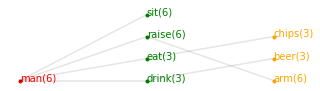

In [17]:
### absorption check
from tools.containers import LayerName
from tools.image_process import getLayerNames
layer = LayerName(getLayerNames('images/Game_day.svg')[-1])#
layer_c = LayerName()
# layer_c.triples_
# print(layer_c.entities_['subj'])
layer_c.absorb(layer)
layer_c.absorb(layer)
layer_c.absorb(layer)
layer_c.triples_
# print(layer)
# print(layer.entities_)
# layer.collapse_subj()
# print(layer.entities_)
# layer.print_()
# layer_c.plot()
print(layer_c.entities_) # plot()
print(layer_c._get_entities())
layer_c.plot()